In [84]:
!pip3 install torch torchvision

In [85]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

## Tensor transformation
````transforms.Normalize((0.5,), (0.5,))```` receive two arguments, first one is the mean and second one is the standard deviation (STD),
all pixels are normalize to this range.<br>
We normalize the image to ````(-1, 1)```` help reduce skewness and distortion of the image

$
minimum value = (0-0.5)/0.5=-1
$

$
maximum value = (1-0.5)/0.5=1
$

In [86]:
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

<u>````im_convert(tensor)````</u> <br><br>convert the image tensor back to numpy array<br>
We use ````detach```` to remove gradient computational.<br>

- tensor argumant: has a shape of $(1, 28, 28)$<br>

To plot the image we require a shape of $(28, 28, 1)$ then denormalize back to (0, 1) by using:<br>
```image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))```

```image.transpose(1, 2, 0):``` will swap axis 0 for axis 1, axis 1 for axis 2 then add axis 0 in the end<br><br>
The result `image` is a numpy array of $(28, 28, 1)$

In [87]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

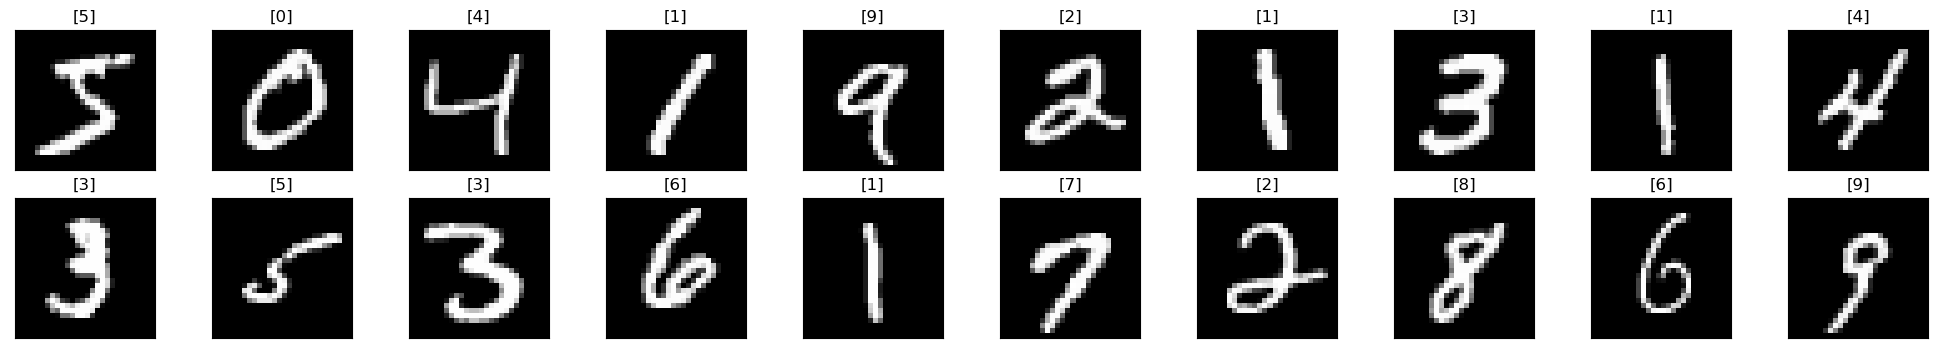

In [88]:
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  image, label = training_dataset[idx]

  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(image))
  ax.set_title([label])


# Create the classifier
We will define a two hidden layers<br>
- `D_in` the size of the input layer
- `H1` the number of node in the first hidden layer
- `H2` the number of node in the second hidden layer
- `out` the size of the output layer

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

>The output of the `forward` method is the <b>'raw'</b> output of linear3. It is intentional since we want to use `nn.CrossEntropyLoss`. Because cross entropy is using logs we just need to pass raw inputs.

`nn.CrossEntropyLoss` calculate the cross entropy <i><b>and</b></i> and the loss itself.

In [89]:
class Classifier(nn.Module):
    
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))  
        x = F.relu(self.linear2(x))
        x = self.linear3(x)        
        return x

- 784 - input layer, size of flatten image
- 125 - size of first input layer
- 065 - size of second input layer
- 010 - size of output layer, since we clasify digits we need 10 outputs

In [90]:
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

## CrossEntropyLoss
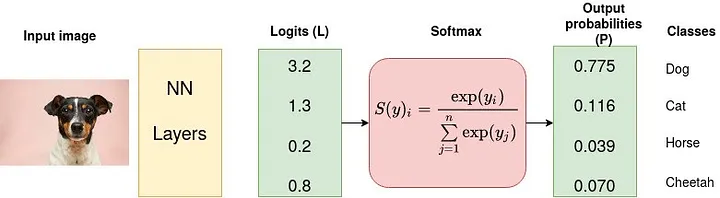

The raw unnormalized output from a Neural Network is converted into probability by a softmax function and then apply cross entropy

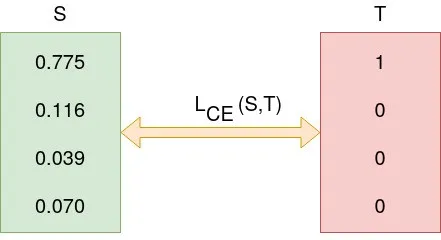

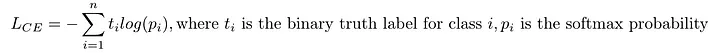

Plugging in the values, we have the loss value:

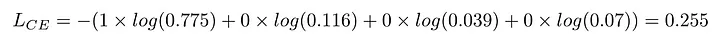

In [91]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

## Training and Validation

First we flatten the inputs images of [1, 28, 28] into a 784 flat vector

In [92]:
for inputs, labels in training_loader:
  print('before view:', inputs.shape)
  inputs = inputs.view(inputs.shape[0], -1)
  print('after view:', inputs.shape)
  print('type(labels)', type(labels))
  print('labels.shape:', labels.shape)
  print('labels.shape[0].item', labels[1].item())
  print('labels.shape[0].item', type(labels[1].item()))
  break

before view: torch.Size([100, 1, 28, 28])
after view: torch.Size([100, 784])
type(labels) <class 'torch.Tensor'>
labels.shape: torch.Size([100])
labels.shape[0].item 8
labels.shape[0].item <class 'int'>


### Eample of one training loop 

````
for inputs, labels in training_loader:
    flaten the imgae - flatten the image into 784 vector
    make a prediction - the output of prediction is <br>raw unnormalize score output</br>
    calculate the loss
    loss.backward - calculate gradient descent and the steps delta using loss.backward
    optimizer.step() - update the new weights according to the gradient descent calculate in the loss.backward method 
    
    select the most suitable output
````    

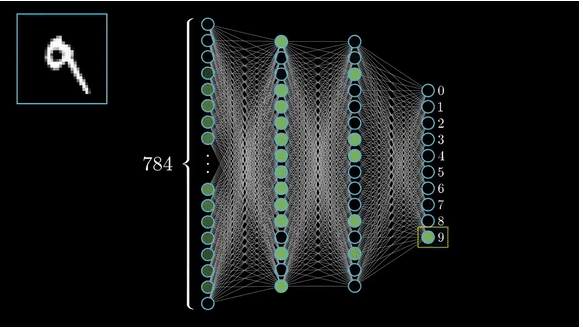

In [93]:
for inputs, labels in training_loader:
  inputs = inputs.view(inputs.shape[0], -1)   # flatten the inputs into [100, 784] matrix
  print('inputs.shape:', inputs.shape, '(100 - is the batch size)')

  outputs = model(inputs)                     # make a prediction
  loss = criterion(outputs, labels)           # calculate the loss using nn.CrossEntorpyLoss
    
  optimizer.zero_grad()   # reset the gradient steps before calculate the step
  loss.backward()         # calculate gradient descent and the steps delta
  optimizer.step()        # update the new weights according to the gradient descent calculate in the loss.backward method 
    
  print('outputs.shape:', outputs.shape)    
  _, preds = torch.max(outputs, 1)
  print('preds:', preds, preds.shape)
  print('torch.sum(preds == labels.data)', torch.sum(preds == labels.data))
  print('loss.item():', loss.item())

  break

inputs.shape: torch.Size([100, 784]) (100 - is the batch size)
outputs.shape: torch.Size([100, 10])
preds: tensor([7, 7, 2, 7, 2, 2, 2, 1, 7, 7, 2, 1, 2, 1, 2, 2, 7, 7, 7, 2, 7, 1, 7, 1,
        7, 7, 7, 4, 7, 7, 4, 8, 0, 7, 2, 4, 2, 7, 7, 7, 2, 2, 3, 7, 1, 2, 8, 4,
        7, 7, 2, 7, 7, 7, 1, 7, 8, 4, 7, 8, 7, 7, 2, 2, 7, 1, 7, 7, 7, 2, 2, 7,
        7, 2, 7, 1, 1, 7, 7, 8, 2, 1, 7, 1, 7, 7, 7, 4, 2, 2, 2, 7, 2, 7, 2, 7,
        2, 7, 2, 7]) torch.Size([100])
torch.sum(preds == labels.data) tensor(6)
loss.item(): 2.2981138229370117


#### Calculating running_corrects
- preds = [2, 3, 4, 5, 6]
- labels = [2, 5, 4, ,5, 6]

Only the second prediction doesn't match the label so the output of `preds == labels` is [1, 0, 1, 1, 1] and `tensor.sum(preds == labels)=4`

In [94]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0], -1)   # flatten the inputs into [100, 784] matrix
    outputs = model(inputs)                     # make a prediction
    loss = criterion(outputs, labels)           # calculate the loss using nn.CrossEntorpyLoss
    
    optimizer.zero_grad()   # reset the gradient steps before calculate the step
    loss.backward()         # calculate gradient descent and the steps delta
    optimizer.step()        # update the new weights according to the gradient descent calculate in the loss.backward method 
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data) # how many images correctly classified

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)

    # len(training_loader) is number of batches in the training set
    epoch_loss = running_loss/len(training_loader)   
    epoch_acc = running_corrects.float()/ len(training_loader)

    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.9470, acc 77.3967 
validation loss: 0.4278, validation acc 88.4500 
epoch : 2
training loss: 0.3747, acc 89.3617 
validation loss: 0.3171, validation acc 90.9000 
epoch : 3
training loss: 0.3132, acc 90.9567 
validation loss: 0.2825, validation acc 91.9300 
epoch : 4
training loss: 0.2808, acc 91.8483 
validation loss: 0.2654, validation acc 92.2700 
epoch : 5
training loss: 0.2576, acc 92.5433 
validation loss: 0.2435, validation acc 92.9000 
epoch : 6
training loss: 0.2371, acc 93.1833 
validation loss: 0.2220, validation acc 93.5400 
epoch : 7
training loss: 0.2184, acc 93.7183 
validation loss: 0.2072, validation acc 93.9400 
epoch : 8
training loss: 0.2031, acc 94.1083 
validation loss: 0.1947, validation acc 94.2200 
epoch : 9
training loss: 0.1886, acc 94.5550 
validation loss: 0.1809, validation acc 94.5900 
epoch : 10
training loss: 0.1766, acc 94.8900 
validation loss: 0.1758, validation acc 94.7300 
epoch : 11
training loss: 0.1653, acc 95.2217 
va

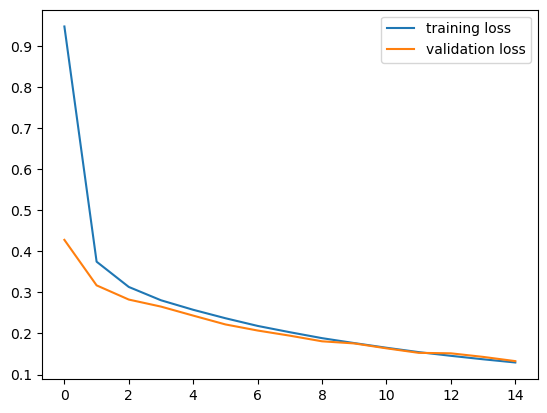

In [95]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

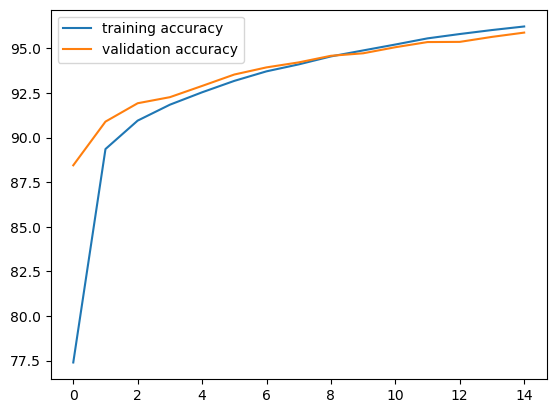

In [96]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [97]:
!pip3 install pillow==4.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 3.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 2.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pillow: filename=Pillow-4.0.0-cp310-cp310-linux_x86_64.whl size=453989 sha256=3cf92bae22c2830972e0fa10d685892fa2f4cb6501a628ca04ec355dd2277c01
  Stored in directory: /home/tsemach/.cache/pip/wheels/29/43/1d/fb88480479d13f585405c24f48c96cad9c6bd6191a219982f3
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35415 sha256=88693e5f87f6ca81e1599a7c11571ed00c7bb9bb5516ea4f2bc74e96a177decd
  Stored in directory: /home/tsemach/.cache/pip/wheels/4d/df/7b/24b97ee860e26da4f0b8867775ee4d94a5e8a0d173484ee74c
Successfully built pillow olefile
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.3.0
    Uninstalling Pillow-9.3.0:
      Successfully uninstalled Pillow-9.3.0
ERRO

In [98]:
import PIL.ImageOps

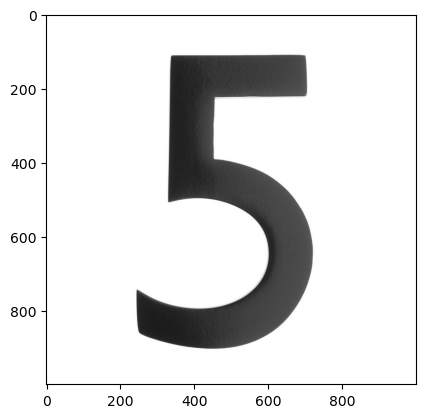

In [103]:
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

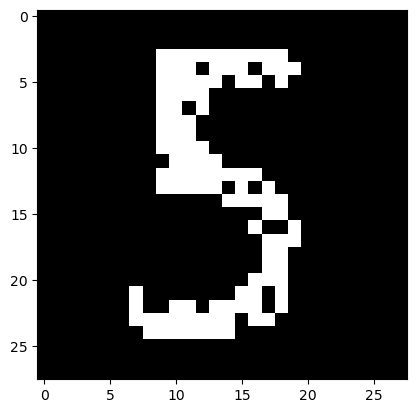

In [100]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(im_convert(img))

In [101]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print(pred.item())

5


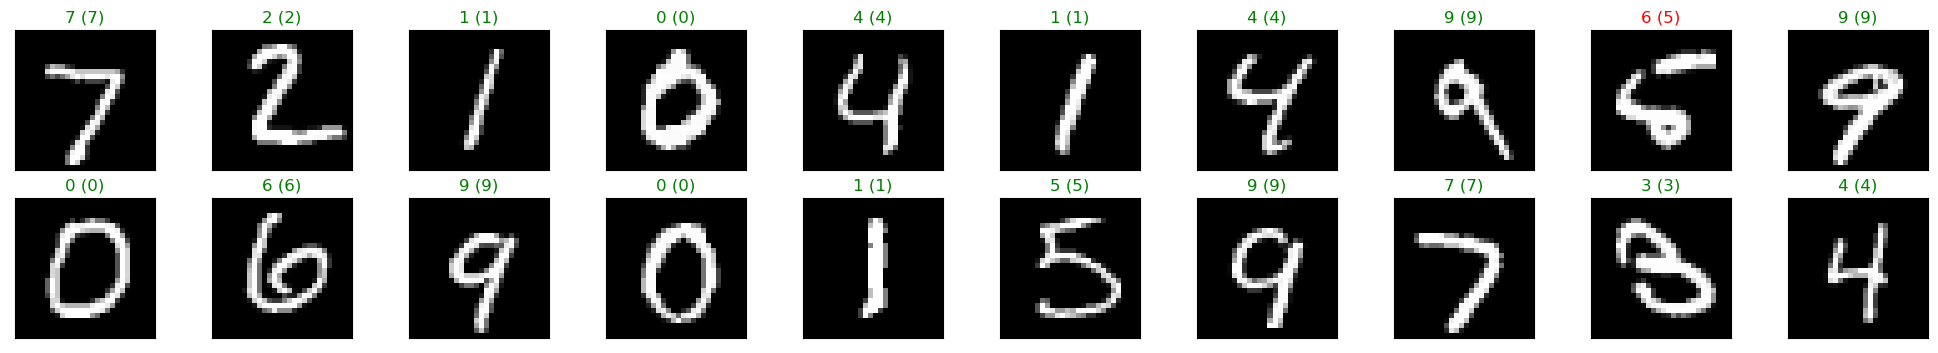

In [102]:
# dataiter = iter(validation_loader)
for images, labels in validation_loader:
  break

images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))